# Exploring Uber and Taxis Data in NYC 

# Introduction
We collect Uber and Taxis data between 04/2014-09/2014 from Taxis and Limousine Commission, and from DataWorld. We explore the data by driving comparison between Uber and Taxis data. 

For Uber data, there are pick-up datetime, pick-up longtitude and latitude, and base number indicating where this driver filed his/her uber license through. For Taxis Data, we have two sets: green and yellow cab. Each of them has pickup_datetime, dropoff_datetime, passenger_count, trip_distance, pickup_longitude, pickup_latitude, dropoff_longtitude, dropoff_latitude, tip_amount, tolls_amount, pickup_type, and total_amount indicating the total taxis fare paid by the passenger.

After analysing both Uber and Taxis data, with yellow cap data we attempt to predict the taxis total fare given pick up location (longtitude and latitude), passenger count and pick up time (hour number). This model can be developed into a real-time system to tell the taxis driver where would be the next heat pick-up location to maximize their profits, or to help thier dispatchers to dispatch taxis in a wiser way.

In [1]:
# ! pip install plotly  pandas numpy sklearn

In [2]:
# Library Imports
import pandas as pd
import numpy as np

import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px

import sklearn
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

from scipy.cluster.vq import kmeans,vq
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt

px.set_mapbox_access_token("pk.eyJ1IjoiYW5nZWwyODAzIiwiYSI6ImNrM2dramE5ejAyMGYzY3A0MnZ5bzcwODMifQ.Ca9djlW3j9B8RpRxguC7VA")

# Table of Contents
* [Explore Uber Data from 04/2014-09/2014](#Explore-Uber-Data)

    * [Uber Trip Distribution in 24hrs](#Uber-Trip-Distribution-in-24hrs)
    
    * [Uber Trip Distribution by Month](#Uber-Trip-Distribution-by-Month)
    
    

* [Explore NYC Taxi Data from 04/2014-09/2014](#Explore-NYC-Taxi-Data)

    * [Taxi Trip Distribution in 24hrs](#Taxi-Trip-Distribution-in-24hrs)
    
    * [Taxi Trip Distribution by Month](#Taxi-Trip-Distribution-by-Month)
    
    * [Other Interesting Findings](#Other-Interesting-Findings)



* [Predicting Taxis Fare with Yellow Cap Data](#Predicting-Taxis-Fare-with-Yellow-Cap-Data)
    
    * [Linear Regression](#Linear-Regression)
    
    * [Naive Bayes Classifier](#Naive-Bayes-Classifier)
    
    * [Kmean Clustering](#Kmean-Clustering)

* [Conclusion](#Conclusion)


# Explore Uber Data


## Load Uber Data

Before we start, we first downloaded all Uber trip data from data world, saved as CSV files and put them under the same directory as our Jupiter Notebook. With all the files needed, we loaded all Uber trip data into memory with name `uber_df`, which has 4,534,327 lines of data in total.



In [3]:
# Load Data
uber_file_names = ['./201404uber.csv', './201405uber.csv', './201406uber.csv', './201407uber.csv', './201408uber.csv', './201409uber.csv']

uber_df_list = [pd.read_csv(uber_file_name) for uber_file_name in uber_file_names]

uber_df = pd.concat(uber_df_list, ignore_index=True)

print(uber_df.shape)

uber_df.head()

(4534327, 4)


Date/Time      Lat      Lon    Base
0  4/1/2014 0:11:00  40.7690 -73.9549  B02512
1  4/1/2014 0:17:00  40.7267 -74.0345  B02512
2  4/1/2014 0:21:00  40.7316 -73.9873  B02512
3  4/1/2014 0:28:00  40.7588 -73.9776  B02512
4  4/1/2014 0:33:00  40.7594 -73.9722  B02512


After we have all the Uber trip data loaded into memories as `uber_df`,  we can do some data cleaning. We first renamed a couple columns to a unified name as NYC Taxi dataset, which we are going to use in the following sections. Then we converted the `pickup_dataset` column to DateTime and set it as index, so that the `uber_df` is time indexed.


In [4]:
# Data Pre-processing
uber_df = uber_df.rename(columns={'Date/Time': 'pickup_datetime', 'Lat': 'pickup_latitude', 'Lon':'pickup_longitude'})
uber_df['pickup_datetime'] = pd.to_datetime(uber_df['pickup_datetime'], format="%m/%d/%Y %H:%M:%S")
uber_df = uber_df.set_index('pickup_datetime')


With the Uber Taxi data loaded and pre-processed, it’s time to do some explorations. 


## Uber Trip Distribution in 24hrs

First, we want to find out the Uber trip distribution in 24 hours, our initial assumption is the trip count in daytime would be larger than the trip count in night.

We first wrote a helper function to automatic generate the desired time ranges, then use the generated time ranges to plot the hourly trip counts. 

### Trip Count in 24 hrs


In [5]:
# Plot ride counts by hour
def time_ranges_gen(gap):
    time_ranges = []
    for i in range(24//gap):
        time_ranges.append(str(i*gap)+':00-'+str((i+1)*gap%24)+':00')
    return time_ranges

def show_rides_per_hour(df, time_gap=1, title='Trip Count Trend in 24 Hours'):
    time_ranges = time_ranges_gen(time_gap)
    print("Group Data By Time Range: ", time_ranges)    
    df_by_time_list = []
    for time_range in time_ranges:
        start_time, end_time = time_range.split('-')
        df_by_time_list.append(len(df.between_time(start_time, end_time)))

    print(df_by_time_list)
    fig = go.Figure([go.Bar(x=time_ranges, y=df_by_time_list)])

    fig.update_layout(
        title={
            'text': title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Time Range",
        yaxis_title="Trip Counts",)

    fig.show()

show_rides_per_hour(uber_df, time_gap=1, title='Trip Count Trend in 24 Hours (Uber)')

Group Data By Time Range:  ['0:00-1:00', '1:00-2:00', '2:00-3:00', '3:00-4:00', '4:00-5:00', '5:00-6:00', '6:00-7:00', '7:00-8:00', '8:00-9:00', '9:00-10:00', '10:00-11:00', '11:00-12:00', '12:00-13:00', '13:00-14:00', '14:00-15:00', '15:00-16:00', '16:00-17:00', '17:00-18:00', '18:00-19:00', '19:00-20:00', '20:00-21:00', '21:00-22:00', '22:00-23:00', '23:00-0:00']
[105218, 68129, 46684, 49147, 56330, 85652, 146133, 196420, 193280, 162453, 161937, 168428, 173596, 199427, 234907, 280558, 318954, 341766, 329846, 299312, 289629, 286083, 245370, 171401]



There are a couple interest things we can find in the plot. First, the plot proves our assumption that the day time has more trips than the night time. Second, we can clearly see the two rush hour periods in a day as there are two peaks in a day, one between 6am and 7am, another between 5pm and 6pm.

### Visualise Variation of Pickup Location in NYC in 24 hrs


After plotting the histogram, we want to visualise how pick-up location varies in NYC in a day. Therefore, by using the one-hour-slot grouped data above, we randomly selected 1000 points in each 1-hour-slot, use thier corresponding latitude and longitude to plot them on a map in a density format.



In [6]:
### Plot heat map
def show_heatmap(data, lat_name='pickup_latitude', lon_name='pickup_longitude', title='Heat Map'):
    z = np.ones(len(data))
    # Street Hail pick up heat map
    fig = go.Figure(go.Densitymapbox(lat=data[lat_name], lon=data[lon_name], z=z, radius=10))
    fig.update_layout(mapbox_style="carto-positron",
                      mapbox_zoom=9.5, mapbox_center = {"lat": 40.7266, "lon": -73.9332})
    fig.update_layout(title={'text': title,
                             'y':0.9,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'})
    fig.show()
    

df_by_time_list = []
for time_range in time_ranges_gen(1):
    start_time, end_time = time_range.split('-')
    df_by_time_list.append(uber_df.between_time(start_time, end_time))

# for df_by_time in df_by_time_list:
#     show_heatmap(df_by_time.sample(n=1000))

show_heatmap(df_by_time_list[0].sample(n=1000), title='Rides between 12:00am and 01:00am')

<!-- ![](https://i.imgur.com/bIeAaT8.gifv) -->
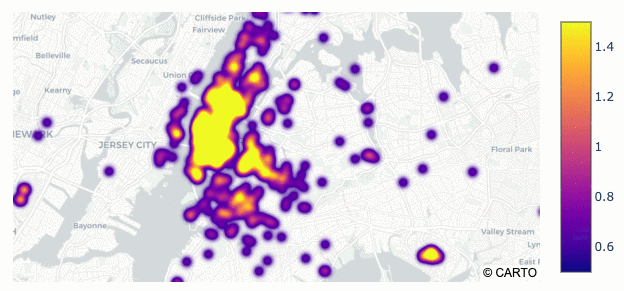


In the dynamic density plot above, we put 24 static map plots (1 hour slot each, i.e. 6:00am-7:00am) together to view the vivid change of pick-up location in NYC varying in 24 hours with yellow indicating popular pick-up zones with more densed data. 

We can see how morning and after-work rush hours affect the density of pick-up zones, and pick up heat rate is always high in mid-town and downtown Manhattan, while the pick up heat rate has a periodical pattern in up-town Manhattan and Brooklyn area.

Besdies, we can also tell the busy periods of JFK and Laguardian Airports from the graph. 

## Uber Trip Distribution by Month
After we view the data by seperating them in 1 hour slot of a day, in this session we view it by month. Therefore, we seperate the data from April 2014 to September 2014 in monthly basis, and plot the total number the trips conducted in each month.

In [7]:
### Plot data by month
def show_rides_per_month():
    month_ranges = ['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']
    trip_per_month = [len(uber_df) for uber_df in uber_df_list]
    
    data = [go.Bar(x=month_ranges, y=trip_per_month)]
    fig = go.Figure(data)

    fig.update_layout(
        title={
            'text': "Trip Count Trend in 6 months",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Month Range",
        yaxis_title="Trip Counts",)

    fig.show()
    
show_rides_per_month()

Regarding the total trip counts in each month from the bar chart above, we can see a clear increase trend from April 2014 to September 2014, which fits the expansion of Uber back in 2014 as it grew rapidly during that period with an increasing number of users.

# Explore NYC Taxi Data

After exploring the Uber data, we move on to the NYC Taxi data to see if we can drive some comparisons between Uber and NYC Taxi data.


## Load Taxi Data

Loading NYC Taxi data became a bit tricky here as they are too large to fit in our memory at the time (2.1GB each, 6 in total), as we were rent a AWS machine with only 8GB of RAM. After some research, we decided that the easiest way to solve this problem is to open another AWS EC2 instance with 32GB of RAM, and so we did. With the support of our new more powerful machine, we were able to load all data into memory and aggregate.

After loaded all data into memory, we pre-processed our data by eliminating all invalid data, renaming column names into same format and convert the time related columns into DateTime format. 

In [8]:
usecols_yellow = [' pickup_datetime', ' dropoff_datetime', ' passenger_count', ' trip_distance', 
                  ' pickup_longitude', ' pickup_latitude', ' dropoff_longitude', ' dropoff_latitude',
                  ' tip_amount', ' tolls_amount', ' total_amount']

usecols_green = ['lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Passenger_count', 'Trip_distance', 
                 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 
                 'Tip_amount', 'Tolls_amount','Trip_type', 'Total_amount']

usecols_uber = ['lpep_pickup_datetime', 'Lpep_dropoff_datetime', 'Passenger_count', 'Trip_distance', 
                 'Pickup_longitude', 'Pickup_latitude', 'Dropoff_longitude', 'Dropoff_latitude', 
                 'Tip_amount', 'Tolls_amount','Trip_type', 'Total_amount']


rename_cols_yellow = {' pickup_datetime':'pickup_datetime', ' dropoff_datetime':'dropoff_datetime', 
                      ' passenger_count': 'passenger_count', ' trip_distance':'trip_distance', 
                      ' pickup_longitude':'pickup_longitude', ' pickup_latitude':'pickup_latitude', 
                      ' dropoff_longitude':'dropoff_longitude', ' dropoff_latitude':'dropoff_latitude',
                      ' tip_amount':'tip_amount', ' tolls_amount':'tolls_amount', ' total_amount':'total_amount'}

rename_cols_green = {'lpep_pickup_datetime':'pickup_datetime', 'Lpep_dropoff_datetime':'dropoff_datetime', 
                     'Passenger_count':'passenger_count', 'Trip_distance':'trip_distance', 
                     'Pickup_longitude':'pickup_longitude', 'Pickup_latitude':'pickup_latitude', 
                     'Dropoff_longitude':'dropoff_longitude', 'Dropoff_latitude':'dropoff_latitude', 
                     'Tip_amount':'tip_amount', 'Tolls_amount':'tolls_amount','Trip_type':'trip_type', 'Total_amount':'total_amount'}

def preprocess(df, ty='yellow'):
    df.drop( df[ df['pickup_latitude'] == 0.0 ].index , inplace=True)
    df.drop( df[ df['pickup_longitude'] == 0.0 ].index , inplace=True)
    df.drop( df[ df['dropoff_longitude'] == 0.0 ].index , inplace=True)
    df.drop( df[ df['dropoff_latitude'] == 0.0 ].index , inplace=True)
    df.drop( df[ df['total_amount'] <= 0.0 ].index , inplace=True)

    
    
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
    
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['dropoff_hour'] = df['dropoff_datetime'].dt.hour

yellow_files = ['./201404yellow.csv', './201405yellow.csv', './201406yellow.csv', './201407yellow.csv', './201408yellow.csv', './201409yellow.csv']
green_files = ['./201404green.csv', './201405green.csv', './201406green.csv', './201407green.csv', './201408green.csv', './201409green.csv']
    
    
yellow201404 = pd.read_csv('./201404yellow.csv', index_col=False, usecols=usecols_yellow).rename(columns=rename_cols_yellow)
preprocess(yellow201404)
# yellow201405 = pd.read_csv('./201405yellow.csv', index_col=False, usecols=usecols_yellow)
# yellow201406 = pd.read_csv('./201406yellow.csv', index_col=False, usecols=usecols_yellow)
# yellow201407 = pd.read_csv('./201407yellow.csv', index_col=False, usecols=usecols_yellow)
# yellow201408 = pd.read_csv('./201408yellow.csv', index_col=False, usecols=usecols_yellow)
# yellow201409 = pd.read_csv('./201409yellow.csv', index_col=False, usecols=usecols_yellow)


green201404 = pd.read_csv('./201404green.csv', index_col=False, usecols=usecols_green).rename(columns=rename_cols_green)
preprocess(green201404)
# green201405 = pd.read_csv('./201405green.csv', index_col=False, usecols=usecols_green)
# green201406 = pd.read_csv('./201406green.csv', index_col=False, usecols=usecols_green)
# green201407 = pd.read_csv('./201407green.csv', index_col=False, usecols=usecols_green)
# green201408 = pd.read_csv('./201408green.csv', index_col=False, usecols=usecols_green)
# green201409 = pd.read_csv('./201409green.csv', index_col=False, usecols=usecols_green)


## Taxi Trip Count Distributions in 24 hrs
We split the Yellow Taxi data and Green Taxi data into 1 hour slots and plotted them separately, in the plotted charts, we find the similar pattern as in the Uber data. The trip count is lower in late night and higher in day time, and there are two peaks representing two rush hour periods.

In [9]:
### Rides per hour
def time_ranges_gen(gap):
    time_ranges = []
    for i in range(24//gap):
        time_ranges.append(str(i*gap)+':00-'+str((i+1)*gap%24)+':00')
    return time_ranges

def show_rides_per_hour(df, time_gap=1, title='Trip Count Trend in 24 Hours'):
    time_ranges = time_ranges_gen(time_gap)
    df_by_time_list = []
    for time_range in time_ranges:
        start_time, end_time = time_range.split('-')
        index = pd.DatetimeIndex(df['pickup_datetime'])
        df_by_time_list.append(len(index.indexer_between_time(start_time, end_time)))
    
    fig = go.Figure([go.Bar(x=time_ranges, y=df_by_time_list)])

    fig.update_layout(
        title={
            'text': title,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Time Range",
        yaxis_title="Trip Counts",)

    fig.show()
    
show_rides_per_hour(yellow201404, 1, title="Yellow Cab Trip Count Trend in 24 Hours")
show_rides_per_hour(green201404, 1, title="Green Cab Trip Count Trend in 24 Hours")

### Trip Count distributions by month

After we view the data by seperating them in 1 hour slot of a day, we seperate the data from April 2014 to September 2014 in monthly basis, and plot the total number the trips conducted in each month, just same as what we did for Uber data.

In [10]:
### Rides per month
def show_rides_per_month():
    ride_per_month = []

    for i in range(6):
        count = 0
        for line in open(yellow_files[i]).readlines(): 
            count += 1

        for line in open(green_files[i]).readlines(): 
            count += 1

        ride_per_month.append(count)
        
    fig = go.Figure([go.Bar(x=['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], y=ride_per_month)])

    fig.update_layout(
        title={
            'text': 'Ride Counts per Month',
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        xaxis_title="Time Range",
        yaxis_title="Trip Counts",)

    fig.show()
    
show_rides_per_month()

This time we didn't find the similar pattern in the NYC Taxi dataset as we found in Uber dataset. That is because NYC Taxi service wasn't expanding rapidly as Uber in 2014.

## Other Interesting Findings
We also found some interesting phenomenon when we were exploring the data, for the green taxis. The Radio Dispathed riders tend to stay away from the Manhattan area, however, the street hail riders tend to go to Manhattan a lot.

In [25]:
# Street Hail
green_street_hail = green201404[ green201404['trip_type'] == 1.0 ].sample(n=500)
green_dispatched = green201404[ green201404['trip_type'] == 2.0 ].sample(n=500)

show_heatmap(green_street_hail, lat_name='pickup_latitude', lon_name='pickup_longitude', title='Green Taxi Street Hail Pick Up')
show_heatmap(green_street_hail, lat_name='dropoff_latitude', lon_name='dropoff_longitude', title='Green Taxi Street Hail Drop Off')
show_heatmap(green_dispatched, lat_name='pickup_latitude', lon_name='pickup_longitude', title='Green Taxi Dispatched Pick Up')
show_heatmap(green_dispatched, lat_name='dropoff_latitude', lon_name='dropoff_longitude', title='Green Taxi Dispatched Drop Off')

# Predicting Taxis Fare with Yellow Cap Data
In this session, given pick up location (longtitude and latitude), passenger count and pick up time (hour number), we want to apply machine learing to see if we can predict the total taxis fare. The total lines of data we deal with here is around 10 million. If the taxis fare can be predicted using the features mentioned, it could be developed into a system that tells the taxis drivers when and where to pickup customers can possibly maximise their profit. Certainly, the prediction result may also be highly related to fuel costs, pick-up distance and traffic conditions, but these factors are not provided in the dataset by organisations.

There are 3 types of learning algorithms used here:
    - Linear Regression
    - Naive Bayes Classification
    - Kmean++ Clustering

## Linear Regression
Linear regression attempts to model the relationship between two or more variables by fitting a linear equation to observed data. It is used here to understand the relationship between input and output numerical variables.

In our case, we want to apply pickup_longitude, pickup_latitude, passenger_count, trip_type, pickup_hour(pickup-time) to a Linear Regression model to predict what the total fare would be.

In [12]:
green201404.drop( green201404[ np.isnan(green201404['trip_type']) ].index , inplace=True)

green201404_1 = green201404[['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 
                 'trip_distance', 'tip_amount', 'trip_type', 'pickup_hour', 'dropoff_hour']]

green201404_2 = green201404[['pickup_longitude', 'pickup_latitude', 'passenger_count', 'trip_type', 'pickup_hour',]]

X = np.asarray(green201404_2)
X_norm = sklearn.preprocessing.normalize(X)

y = np.asarray(green201404['total_amount']).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.33, random_state=42)

# print(X_train)

# print(np.any(np.isnan(green201404)))

reg = LinearRegression().fit(X_train, y_train)

print(reg.score(X_test, y_test))

print('coef\n', reg.coef_)

print('intercept\n', reg.intercept_)

print('score\n', reg.score(X_test, y_test))

print('Predict')

y_pred = reg.predict(np.asarray(X_test))
y_test = y_test
                     
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


0.015626076326534344
coef
 [[ -922.55987935 -1393.32531086    13.02261948   544.64982769
     17.80594594]]
intercept
 [-128.15255333]
score
 0.015626076326534344
Predict
Mean Absolute Error: 7.1540125416742155
Mean Squared Error: 120.54724698436894
Root Mean Squared Error: 10.979401030309848


In our model here, we can see that only 1.5% of the variability in total_taxis_fare can be explained using by our chosen variables. Regarding the Root Mean Squared Error, we can tell that we are an average of 11 dollars away from the ground truth total taxis fare when making predictions on our test set. For the relavance between total taxis fare and other variables, we can see a huge difference between location (longitude and latitude) and other variables. That's because the change in longitude and latitude within the whole NYC is as small as 0.01 which means that a tiny change in pickup location might have the same effect on taxis total fare like other varibales as  the change passenger count would be as large as n (n >= 0, integer).

In conlusion, Linear Regression did a pretty bad job in predicting total taxis fare given the chosen variables.

## Naive Bayes Classifier
Since Linear Regression model does not give us a very good result, in this session we switch to a supervised classification technique which is based on Bayes’ Theorem with an assumption of independence among predictors. In simple terms, a Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other feature. As we need to propose classes to the model, we first get the mean value of what we try to predict, i.e. total_taxis_fare, and make two classes for the model: class 0 < mean_fare, class 1 >= mean_fare.

In [13]:
yellow = yellow201404
# data clean up with incorrect yellow taxis pickup_latitude, pickup_longtitude values
yellow.drop(yellow[yellow['pickup_latitude'] >= 41].index, inplace= True)
yellow.drop(yellow[yellow['pickup_longitude'] <= -75].index, inplace= True)

In [14]:
# classify total_amount into 2 ranges
mean_fare = np.mean(yellow['total_amount'])
conditions = [yellow['total_amount'] < mean_fare, yellow['total_amount'] >= mean_fare]
outputs = [0, 1]
res = np.select(conditions, outputs, 'Other')
yellow['label'] = res

yellow.head()

pickup_datetime    dropoff_datetime  passenger_count  trip_distance  \
0 2014-04-08 08:59:39 2014-04-08 09:28:57                1            2.5   
2 2014-04-08 08:45:28 2014-04-08 08:50:41                2            0.6   
3 2014-04-08 08:00:20 2014-04-08 08:11:31                2            0.5   
4 2014-04-08 08:38:36 2014-04-08 08:44:37                1            0.4   
5 2014-04-08 07:52:53 2014-04-08 07:59:12                1            0.8   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.958848        40.763585         -73.986284         40.752034   
2        -73.992233        40.729136         -73.991387         40.735186   
3        -73.973726        40.750095         -73.976889         40.755623   
4        -73.973502        40.755479         -73.979198         40.758619   
5        -73.963002        40.766355         -73.953768         40.778865   

   tip_amount  tolls_amount  total_amount  pickup_hour  dropoff_hour label  
0         3.7           0.0          22.2            8             9     1  
2         1.2           0.0           7.2            8             8     0  
3         1.7           0.0          10.2            8             8     0  
4         1.2           0.0           7.2            8             8     0  
5         1.3           0.0           7.8            7             7     0

In [15]:
# data prepared to fit in Naive Bayes Classifier
length = len(yellow['passenger_count'])

pc = (yellow['passenger_count'].to_numpy()).reshape((length, 1))
plo = (yellow['pickup_longitude'].to_numpy()).reshape((length, 1))
pla = (yellow['pickup_latitude'].to_numpy()).reshape((length, 1))
ph = (yellow['pickup_hour'].to_numpy()).reshape((length, 1))


tm = (yellow['total_amount'].to_numpy()).reshape((length, 1))


data = np.hstack((pc, plo, pla, ph))
label = (yellow['label'].to_numpy())

In [16]:
# naive bayes

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3, random_state=103) # 70% training and 30% test

#Create a Gaussian Classifiers
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = gnb.predict(X_test)

In [17]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.7105732314176499
              precision    recall  f1-score   support

           0       0.71      0.98      0.83   2992831
           1       0.69      0.08      0.14   1295943

    accuracy                           0.71   4288774
   macro avg       0.70      0.53      0.48   4288774
weighted avg       0.70      0.71      0.62   4288774



From the prediction result above, we can tell that the general accuracy is around 71%, which indicates our classifier did a pretty good job on predicting those 30% test data. However, if we look closer, we realise that although the precision percentages of both class 0 and class 1 are fairly high, 71% and 69% respectively, the reall score of class 1 is very low which is only 8%. To understand this, we compare class 1's precision score 69% and recall score 8%, where Precision = TruePositive/(TruePositive+FalsePositive), Recall = TruePositive/(TruePositive+FalseNegative), and realize that the number of FalseNegative point might be huge so it drags down the recall by so much. In a more interpretative way to understand this, we can say that out of X total fare datapoints that our classifier claimed as >= mean fare 15 dollars, there are actually a lot of datapoints fell in < 15 dollars range but our classifier failed to detect them.

To further understand why class 0 result is so much better than class 1, we plot to see how many datapoints of the whole dataset are in the class 0 and in class 1.

In [18]:
# plot bar chart
y = [len(yellow[ yellow['label'] == '0' ]), len(yellow[ yellow['label'] == '1']) ]
x = ['Low Pay', 'High Pay']

data = [go.Bar(x=x, y=y)]

# # Plot the chart

fig = go.Figure(data)

fig.update_layout(
    title={
        'text': "Trip Type",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title="Type",
    yaxis_title="Trip Counts",)

fig.show()

We can see from the plot that the trip counts of low pay (<\\$15) is more than twice of the trip counts of high pay (>=\\$15), so we made a conjecture that our train data contains much more low pay than high pay so our model might have higher possibility to predict a given point leaning towards low pay. When it comes to the result, since the model tends to predict low pay (class 0) more often, and the number of low pay points is more than the hight pay ones in the test dataset, the general accuracy might be higher for this reason, and it also in some way explains why the recall score of class 0 is much higher than the recall score of class 1.

## K-means Clustering
From the last session we can see that the Naive Bayes Model yeilds a fair result in predicting which money range would the total fare amounts fall in. In this session, we will use K-means Clustering to see if this would give a better model.

K-means is an Unsupervised Learning Algorithm, where there are indeed no right or wrong answers. We are just given data points and absolutely no response variables. It's more intended to find structure in data based on certain targeted requirements. 

In [20]:
# Data prepared for Kmean Clustering
length = len(yellow['passenger_count'])
# yellow.drop(yellow[yellow['pickup_latitude'] >= 41].index, inplace= True)
# yellow.drop(yellow[yellow['pickup_longitude'] <= -75].index, inplace= True)

pc = (yellow['passenger_count'].to_numpy()).reshape((length, 1))
plo = (yellow['pickup_longitude'].to_numpy()).reshape((length, 1))
pla = (yellow['pickup_latitude'].to_numpy()).reshape((length, 1))
ph = (yellow['pickup_hour'].to_numpy()).reshape((length, 1))
tm = (yellow['total_amount'].to_numpy()).reshape((length, 1))

X = np.hstack((pc, plo, pla, ph, tm))
sample = 100000
X = X[np.random.randint(X.shape[0], size=sample), :]

X_norm = sklearn.preprocessing.normalize(X)

### Choose appropriate K -- cluster number
Similar to Naive Bayes which requires a defined class, K-means requires us to sepcify the number of clusters k. Thus, we use the Elbow Method to see which k is the most suitable one for our dataset. 

This method tracks how "tight" a cluster is. It operates on each cluster and adds up the squares of the distance of each point in a cluster from the centroid of the cluster. That is, for each point in a cluster we take the distance between that point and the centroid of the cluster and square it. We do this for each point in the cluster and then we sum it for that cluster. Then we repeat this step for each cluster.

When we have a "good" or tight cluster, individual distances will be small and hence the sum of squares for that cluster be small. For a "bad" or loose cluster the opposite is true.

When we increase the value of k, the value of "within-cluster-sum-of-squares" will drop as we have more clusters hence smaller distances to centroids. But each successive increase in K will not give the same drop. At some point the improvement will start to level off. We call that value of k the elbow and use that as the "good" value of k. In our case, the suitable value for k is 3.

In [21]:
# cluster data into K=1..10 clusters

K = range(1,10)

# scipy.cluster.vq.kmeans
KM = [kmeans(X,k) for k in K] # apply kmeans 1 to 10
centroids = [cent for (cent,var) in KM]   # cluster centroids

D_k = [cdist(X, cent, 'euclidean') for cent in centroids]

cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]
avgWithinSS = [sum(d)/X.shape[0] for d in dist] 

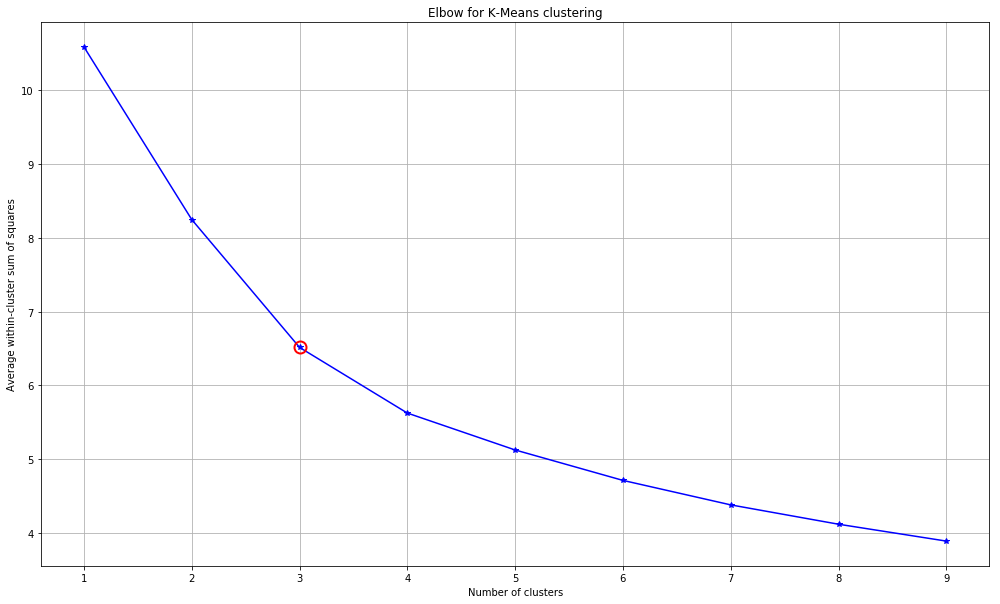

In [22]:
kIdx = 2
# plot elbow curve
plt.rcParams['figure.figsize'] = [17, 10]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(K, avgWithinSS, 'b*-')
ax.plot(K[kIdx], avgWithinSS[kIdx], marker='o', markersize=12, 
      markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.grid(True)
plt.xlabel('Number of clusters')
plt.ylabel('Average within-cluster sum of squares')
tt = plt.title('Elbow for K-Means clustering')

### Apply K-means Clustering with k = 3

In [23]:
km = KMeans(3, init='k-means++') # initialize
km.fit(X)
c = km.predict(X) # classify into three clusters

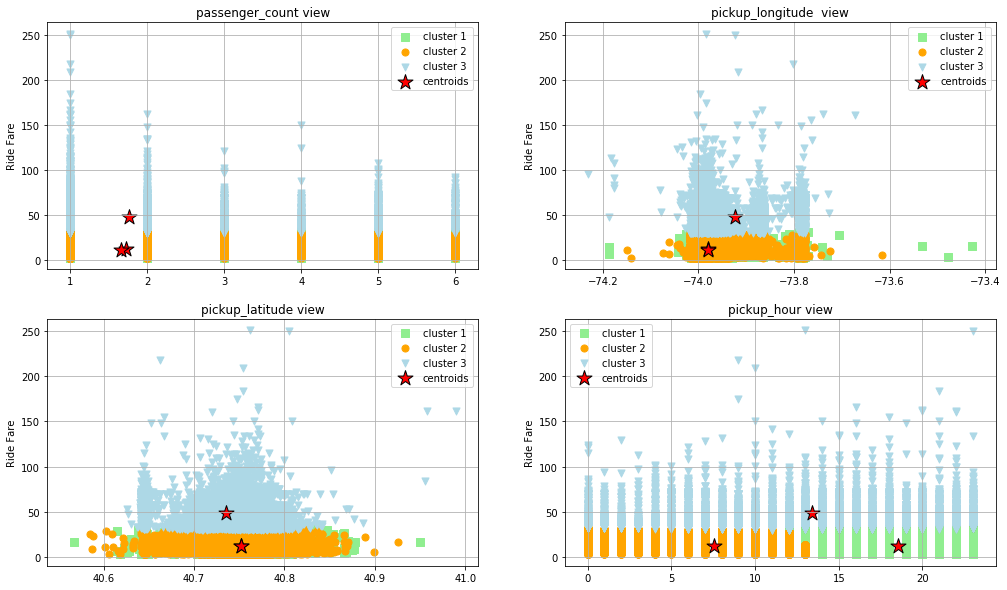

In [24]:
# plot the 3 clusters
def plot_clusters(plot, c, surface, title):
    plot.set_title(title)
    
    plot.scatter(
        X[c == 0, surface], X[c == 0, 4],
        s=50, c='lightgreen',
        marker='s', 
        label='cluster 1'
    )

    plot.scatter(
        X[c == 1, surface], X[c == 1, 4],
        s=50, c='orange',
        marker='o', 
        label='cluster 2'
    )

    plot.scatter(
        X[c == 2, surface], X[c == 2, 4],
        s=50, c='lightblue',
        marker='v', 
        label='cluster 3'
    )

    # plot the centroids
    plot.scatter(
        km.cluster_centers_[:, surface], km.cluster_centers_[:, 4],
        s=250, marker='*',
        c='red', edgecolor='black',
        label='centroids'
    )

    plot.legend(scatterpoints=1)
    plot.grid()
    plot.set_ylabel('Ride Fare')


fig, axs = plt.subplots(2, 2)

plot_clusters(axs[0, 0], c=c, surface=0, title='passenger_count view')

plot_clusters(axs[0, 1], c=c, surface=1, title='pickup_longitude  view')

plot_clusters(axs[1, 0], c=c, surface=2, title='pickup_latitude view')

plot_clusters(axs[1, 1], c=c, surface=3, title='pickup_hour view')

fig.show()

After we applied the k-means clustering, we can see from each chart that the cluster has been "forced" out. For each chart, the x-axis are the varibales we feed into the model, and the y-axis is always total-taxis-fare. It is quite obvious that for passenger_count, pickup_longitude, and pickup_latitude, the data are not quite "clusterable", we cannot even see a clear seperation of the data or centroids. When it comes to pickup_hour, it is slightly better, but we can tell from the right bottom graph that although there are three clusters seperated but all data are still very close to each other, indicating that K-means clustering is not the Mr.MachineLearningRight for this dataset.

# Conclusion

In the data exploring section, we compared two datasets, the Uber dataset and NYC Taxi dataset, and discovered some interesting findings. In the machine learning section, we used three different types of machine learning algorithms, Linear Regression, Naive Bayes Classification and Kmean++ Clustering, trying to predict taxi fare with the given data. However, based on the performance of all these algorithms, we concluded that none of those algorithms are good enough to predict the taxi fares.